In [1]:
import numpy as np                     # Numerical operations and array manipulation
import pandas as pd                    # Data loading, cleaning, and DataFrame operations
import os                              # Interacting with the operating system (paths, directories)
from datetime import datetime           # Working with date and time formats
import matplotlib.pyplot as plt         # Visualization and plotting

from sklearn.ensemble import RandomForestRegressor   # Machine learning model for regression
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             confusion_matrix)       # Performance evaluation metrics

import tensorflow as tf                 # Deep learning framework
from tensorflow.keras import layers, models, callbacks   # Neural network layers, models, and training callbacks


In [7]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.4/249.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 12.5 MB/s eta 0:00:00


In [2]:
df = pd.read_csv("/content/synthetic_load_with_missing.csv") #Reading CSV data


In [3]:
df

,date,hour,dayofweek,dayofyear,temp,solar,wind,load
0,2023-01-01 00:00:00,0,6,1,10.668848,-0.076225,1.738539,17.533565
1,2023-01-01 01:00:00,1,6,1,11.327964,0.532552,2.098603,NaN
2,2023-01-01 02:00:00,2,6,1,13.319822,0.521505,1.151178,10.328752
3,2023-01-01 03:00:00,3,6,1,15.230697,0.928072,2.683639,13.847641
4,2023-01-01 04:00:00,4,6,1,14.268107,1.453223,0.438029,11.776826
...,...,...,...,...,...,...,...,...
17515,2024-12-30 19:00:00,19,0,365,4.990638,1.941582,2.420383,NaN
17516,2024-12-30 20:00:00,20,0,365,5.741537,1.473527,2.487524,33.009601
17517,2024-12-30 21:00:00,21,0,365,7.161098,0.901019,1.724524,29.930362
17518,2024-12-30 22:00:00,22,0,365,8.137333,0.600472,1.898154,24.689380


                           MISSING VALUE PREPROCESSING

In [4]:
from statsmodels.tsa.arima.model import ARIMA

# Create an ARIMA(2,1,2) model on the 'load' time series (2 AR terms, 1 differencing, 2 MA terms)
model = ARIMA(df['load'], order=(2,1,2))

# Fit the ARIMA model to learn parameters and generate in-sample predictions
res = model.fit()

# Fill missing values in the 'load' column using the ARIMA model's predicted values
df['load'] = df['load'].fillna(pd.Series(res.predict()))


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [5]:
df

,date,hour,dayofweek,dayofyear,temp,solar,wind,load
0,2023-01-01 00:00:00,0,6,1,10.668848,-0.076225,1.738539,17.533565
1,2023-01-01 01:00:00,1,6,1,11.327964,0.532552,2.098603,17.533648
2,2023-01-01 02:00:00,2,6,1,13.319822,0.521505,1.151178,10.328752
3,2023-01-01 03:00:00,3,6,1,15.230697,0.928072,2.683639,13.847641
4,2023-01-01 04:00:00,4,6,1,14.268107,1.453223,0.438029,11.776826
...,...,...,...,...,...,...,...,...
17515,2024-12-30 19:00:00,19,0,365,4.990638,1.941582,2.420383,40.867940
17516,2024-12-30 20:00:00,20,0,365,5.741537,1.473527,2.487524,33.009601
17517,2024-12-30 21:00:00,21,0,365,7.161098,0.901019,1.724524,29.930362
17518,2024-12-30 22:00:00,22,0,365,8.137333,0.600472,1.898154,24.689380


                                         PROPHET ESTIMATION

In [ ]:
# Install/upgrade prophet and pystan (run separately if needed)
# !pip install --upgrade prophet pystan

# ---------------------------
# Import Required Libraries
# ---------------------------
import pandas as pd                     # For data handling
import numpy as np                      # For numerical operations
from prophet import Prophet             # Prophet forecasting model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt                  # For RMSE calculation

# ---------------------------
# Metrics Function
# Computes MAE, RMSE, and MAPE
# ---------------------------
def compute_metrics(y_true, y_pred):

    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)

    # Root Mean Squared Error
    rmse = sqrt(mean_squared_error(y_true, y_pred))

    # Mean Absolute Percentage Error
    # |actual - predicted| / actual * 100
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100

    return {"MAE": mae, "RMSE": rmse, "MAPE(%)": mape}


# ---------------------------
# Prophet Forecast Function
# df         : DataFrame containing time series
# test_h     : Number of future steps to forecast (test horizon)
# Returns    : timestamps, actual values, predictions, metrics
# ---------------------------
def fit_prophet_and_predict(df, test_h=24):

    # Reset index so Prophet gets columns: ds (date) and y (target)
    df_p = df.reset_index().rename(columns={'index': 'ds', 'load': 'y'})

    # Train/test split
    train = df_p[:-test_h]     # All except last test_h records
    test = df_p[-test_h:]      # Last test_h records for evaluation

    # Initialize Prophet model with seasonality components
    m = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True
    )

    # Check if extra regressors are present and add them to Prophet
    for reg in ['temp', 'solar', 'wind']:
        if reg in df_p.columns:
            m.add_regressor(reg)

    # Fit Prophet model on training data
    m.fit(train)

    # Prepare future dataframe (dates + regressors for test horizon)
    future = test[['ds']].copy()
    for reg in ['temp', 'solar', 'wind']:
        if reg in test.columns:
            future[reg] = test[reg]

    # Generate forecast
    forecast = m.predict(future)

    # Extract predicted values
    pred = forecast['yhat'].values

    # Extract actual values
    y_test = test['y'].values

    # Return results + metrics
    return test['ds'], y_test, pred, compute_metrics(y_test, pred)


# ---------------------------
# Example Usage (Synthetic Data)
# ---------------------------

# Create a date range (hourly frequency for 30 days)
rng = pd.date_range("2024-01-01", periods=24*30, freq='h')

# Generate synthetic load data: baseline + daily sinusoidal + noise
load = 100 + 10 * np.sin(2*np.pi*rng.hour/24) + np.random.normal(0, 3, len(rng))

# Create DataFrame with load column
df = pd.DataFrame({'load': load}, index=rng)

# Run Prophet forecasting with a 48-hour test horizon
idx_test, y_test, pred, metrics = fit_prophet_and_predict(df, test_h=48)




In [11]:
# Print error metrics
print("Metrics:", metrics)
result = pd.DataFrame({"timestamp": idx_test, "actual": y_test, "forecast_prophet": pred})
print(result.head())

Metrics: {'MAE': 2.494197574276363, 'RMSE': 3.077815304840984, 'MAPE(%)': np.float64(2.4396282817255655)}
              timestamp      actual  forecast_prophet
672 2024-01-29 00:00:00  100.327845         99.905194
673 2024-01-29 01:00:00   98.609080        102.399993
674 2024-01-29 02:00:00  101.654519        104.905855
675 2024-01-29 03:00:00  103.945340        107.123186
676 2024-01-29 04:00:00  105.769353        108.788535


Metrics: {'MAE': 3.3105855468689764, 'RMSE': 4.041747403636368, 'MAPE(%)': np.float64(3.2549446181681625)}
              timestamp      actual  forecast_prophet
672 2024-01-29 00:00:00   94.517388         99.265204
673 2024-01-29 01:00:00  100.659848        101.858758
674 2024-01-29 02:00:00  110.276790        104.214535
675 2024-01-29 03:00:00  106.545665        106.222385
676 2024-01-29 04:00:00  107.845016        107.765766


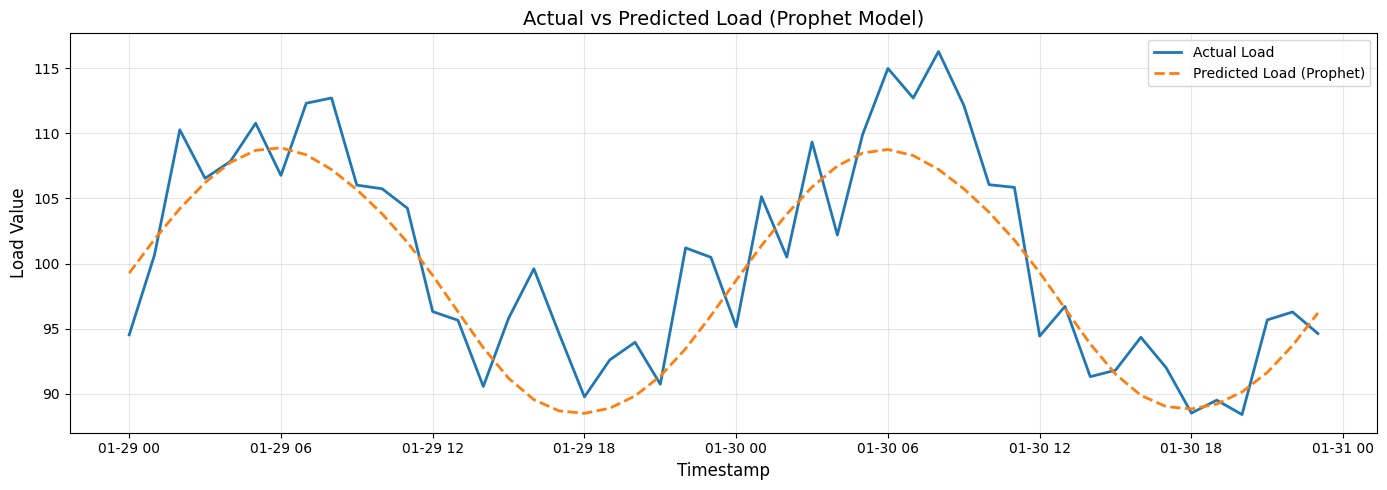

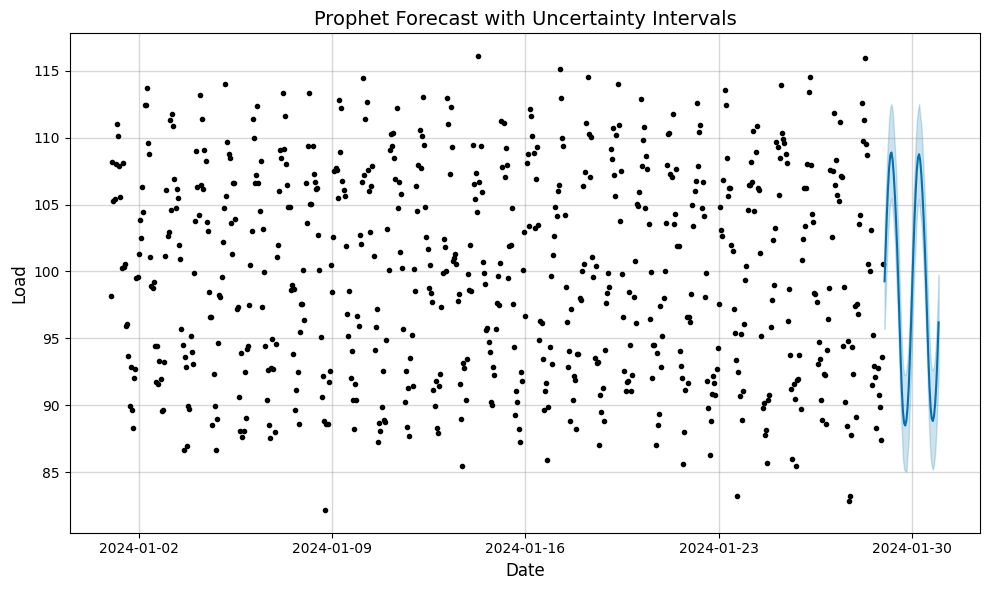

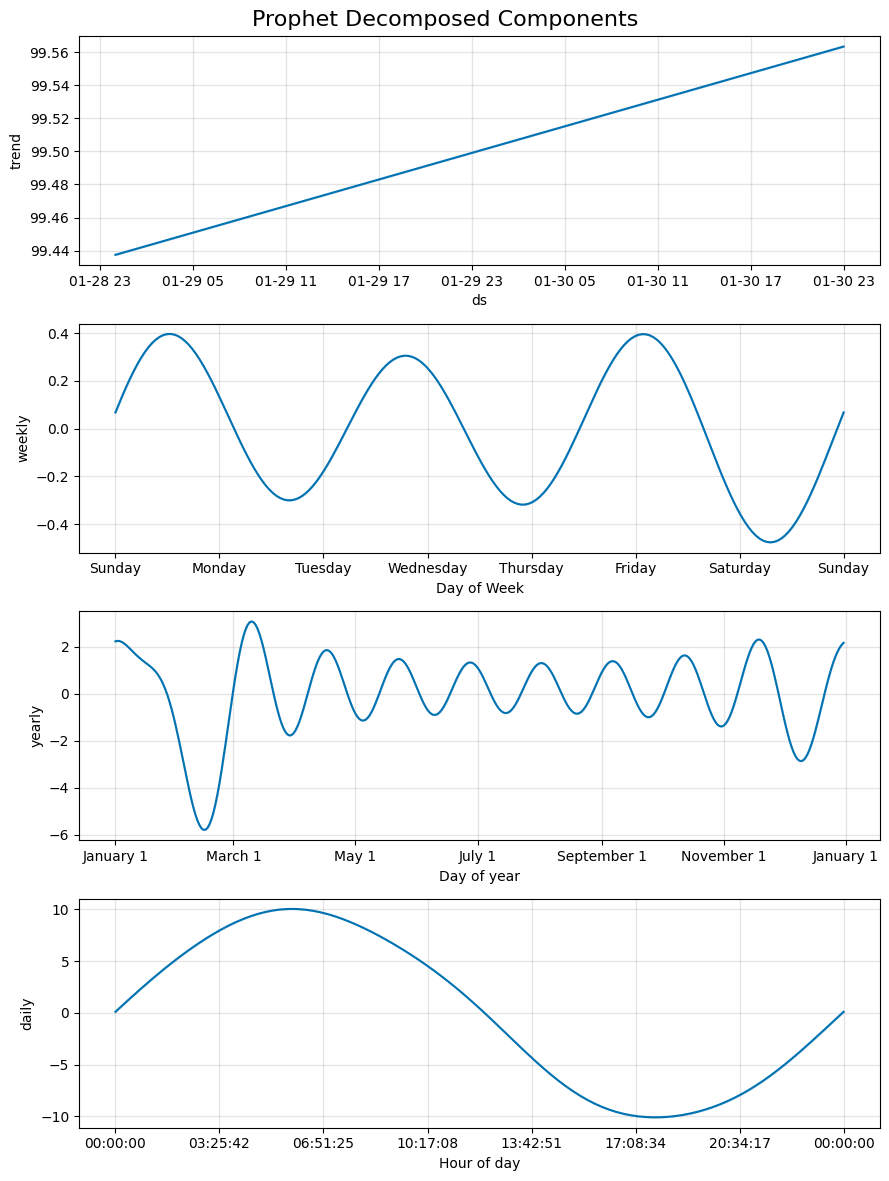

In [12]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# ============================================================
# Function: Compute Forecast Metrics
# Calculates MAE, RMSE, and MAPE for evaluating the model.
# ============================================================
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)  # Mean Absolute Error
    rmse = sqrt(mean_squared_error(y_true, y_pred))  # Root Mean Square Error
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100  # MAPE in %
    return {"MAE": mae, "RMSE": rmse, "MAPE(%)": mape}

# ============================================================
# Function: Train Prophet and Predict Future Values
# df      → input DataFrame containing index as timestamp & column 'load'
# test_h  → number of future steps reserved for testing
# Returns model, forecast result, test timestamp, actual values, predictions, metrics
# ============================================================
def fit_prophet_and_predict(df, test_h=24):

    # Prepare data in Prophet-required format
    df_p = df.reset_index().rename(columns={'index': 'ds', 'load': 'y'})

    # Split into train and test
    train = df_p[:-test_h]     # all except last test_h points
    test = df_p[-test_h:]      # last test_h points for testing

    # Initialize Prophet model with standard seasonalities
    m = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True
    )

    # Add regressors if available in the DataFrame
    for reg in ['temp', 'solar', 'wind']:
        if reg in df_p.columns:
            m.add_regressor(reg)

    # Fit the model
    m.fit(train)

    # Prepare future dataframe (test period only)
    future = test[['ds']].copy()
    for reg in ['temp', 'solar', 'wind']:
        if reg in test.columns:
            future[reg] = test[reg]

    # Generate predictions
    forecast = m.predict(future)

    pred = forecast['yhat'].values   # predicted load
    y_test = test['y'].values        # actual test load

    # Return everything including evaluation metrics
    return m, forecast, test['ds'], y_test, pred, compute_metrics(y_test, pred)

# ============================================================

# ============================================================

rng = pd.date_range("2024-01-01", periods=24*30, freq='h')  # 30 days hourly data

# Synthetic load with sinusoidal daily pattern + noise
load = 100 + 10 * np.sin(2 * np.pi * rng.hour / 24) + np.random.normal(0, 3, len(rng))

# Create DataFrame with timestamp index
df = pd.DataFrame({'load': load}, index=rng)

# Fit model and predict last 48 hours
m, forecast, idx_test, y_test, pred, metrics = fit_prophet_and_predict(df, test_h=48)


# Store forecast comparison result
result = pd.DataFrame({"timestamp": idx_test, "actual": y_test, "forecast_prophet": pred})
print(result.head())

# ============================================================
# Visualization Section
# ============================================================

# ------------------------------------------------------------
# Plot 1: Actual vs Predicted Load (Test Period)
# ------------------------------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(idx_test, y_test, label="Actual Load", linewidth=2)
plt.plot(idx_test, pred, label="Predicted Load (Prophet)", linestyle="--", linewidth=2)

plt.title("Actual vs Predicted Load (Prophet Model)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Load Value", fontsize=12)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot 2: Prophet Full Forecast with Confidence Intervals
# ------------------------------------------------------------
fig1 = m.plot(forecast)
plt.title("Prophet Forecast with Uncertainty Intervals", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Load", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot 3: Prophet Component Plots (Trend, Yearly, Weekly)
# ------------------------------------------------------------
fig2 = m.plot_components(forecast)
plt.suptitle("Prophet Decomposed Components", fontsize=16)
plt.tight_layout()
plt.show()


In [25]:

print("Metrics:", metrics)

Metrics: {'MAE': 3.3663503794610454, 'RMSE': 4.308458277747867, 'MAPE(%)': np.float64(3.489085174529766)}


In [14]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 9.0 MB/s eta 0:00:00


                                              ARIMA ESTIMATION

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# --------------------------------------------------
# Function: Compute Error Metrics
# --------------------------------------------------
# This function calculates three commonly used error metrics
# to evaluate forecasting performance:
#   - MAE  : Mean Absolute Error
#   - RMSE : Root Mean Squared Error
#   - MAPE : Mean Absolute Percentage Error (%)
def compute_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE(%)": np.mean(np.abs((np.array(y_true)-np.array(y_pred)) / np.array(y_true))) * 100
    }

# --------------------------------------------------
# Function: ARIMA Forecasting
# --------------------------------------------------
# This function:
#   1. Splits the time series into training + testing sets
#   2. Automatically selects the best ARIMA(p,d,q)(P,D,Q)m model using auto_arima
#   3. Predicts future 'test_h' number of values
#   4. Returns predictions and error metrics
def arima_forecast(series, test_h=48):

    # Split into train and test
    train, test = series[:-test_h], series[-test_h:]

    # Fit ARIMA model automatically with seasonal period m=24 (daily seasonality for hourly data)
    model = auto_arima(
        train,
        seasonal=True,
        m=24,                     # 24 hours = daily seasonality
        trace=False,
        error_action="ignore",
        suppress_warnings=True
    )

    # Predict for next 'test_h' hours
    forecast = model.predict(n_periods=test_h)

    # Return test timestamps, actual values, predicted values, and evaluation metrics
    return test.index, test.values, forecast, compute_metrics(test.values, forecast)

# --------------------------------------------------
# Example: Synthetic Load Data (Hourly)
# --------------------------------------------------
# Creating example data for demonstration:
#   - 30 days of hourly load values
#   - Contains a daily sinusoidal pattern + random noise
rng = pd.date_range("2024-01-01", periods=24*30, freq='h')
load = 100 + 8*np.sin(2*np.pi*rng.hour/24) + np.random.normal(0, 3, len(rng))

# Convert to pandas Series
series = pd.Series(load, index=rng)

# Run ARIMA forecasting with 48-hour test horizon
idx_test, y_test, pred, metrics = arima_forecast(series, test_h=48)

print("ARIMA Metrics:", metrics)

# --------------------------------------------------
# Visualization
# --------------------------------------------------
# Plot showing:
#   - Full historical series (light)
#   - Actual test values
#   - ARIMA forecast
plt.figure(figsize=(12,4))

plt.plot(series.index, series, label="Full Series", alpha=0.4)
plt.plot(idx_test, y_test, label="Actual", linewidth=2)
plt.plot(idx_test, pred, '--', label="ARIMA Forecast", linewidth=2)

plt.title("ARIMA Forecast vs Actual", fontsize=14)
plt.xlabel("Timestamp")
plt.ylabel("Load")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
print("ARIMA Metrics:", metrics)

ARIMA Metrics: {'MAE': 3.3663503794610454, 'RMSE': 4.308458277747867, 'MAPE(%)': np.float64(3.489085174529766)}


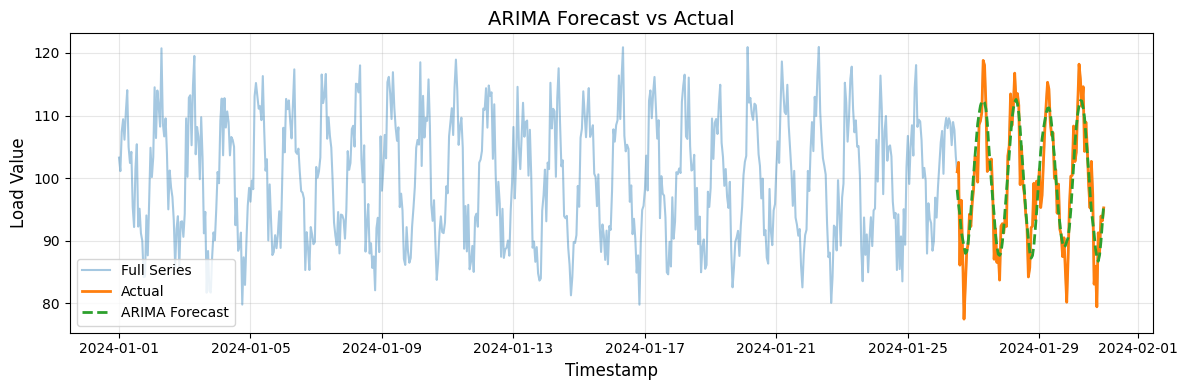

In [22]:
plt.figure(figsize=(12,4))

# Full historical series (light color)
plt.plot(series.index, series, label="Full Series", alpha=0.4)

# Actual test values
plt.plot(idx_test, y_test, label="Actual", linewidth=2)

# ARIMA predictions
plt.plot(idx_test, pred, '--', label="ARIMA Forecast", linewidth=2)

# Title and axis labels
plt.title("ARIMA Forecast vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Load Value", fontsize=12)

# Details
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()


                                                
                                                LSTM ESTIMATION


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras import layers, models

# --------------------------------------------------
# Function: Compute Error Metrics
# --------------------------------------------------
# Calculates evaluation metrics:
#   - MAE   : Mean Absolute Error
#   - RMSE  : Root Mean Square Error
#   - MAPE  : Mean Absolute Percentage Error
def compute_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE(%)": np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    }

# --------------------------------------------------
# Function: Convert Time Series into Sequences
# --------------------------------------------------
# Creates training samples for LSTM.
# Example:
#   For seq_len=24, each input sample contains the past 24 hours,
#   and the label is the next hour's load value.
def create_sequences(arr, seq_len=24):
    X, y = [], []
    for i in range(seq_len, len(arr)):
        X.append(arr[i - seq_len:i])   # past seq_len values
        y.append(arr[i])               # next value
    return np.array(X), np.array(y)

# --------------------------------------------------
# Function: LSTM Forecasting
# --------------------------------------------------
# Steps:
#   1) Normalize data (train mean & std)
#   2) Build sequences for train & test
#   3) Train an LSTM model
#   4) Predict test values and denormalize
def lstm_forecast(series, seq_len=24):

    # Convert series to 2D array (required by LSTM)
    values = series.values.reshape(-1, 1).astype(float)

    # --- Train/Test Split (85% training, 15% testing) ---
    train_len = int(len(values) * 0.85)
    train, test = values[:train_len], values[train_len:]

    # --- Normalization (using only training statistics) ---
    mean, std = train.mean(), train.std() + 1e-6
    train_n = (train - mean) / std
    test_n  = (test  - mean) / std

    # --- Build LSTM sequences ---
    X_train, y_train = create_sequences(train_n, seq_len)

    # For testing: last seq_len of train + full test
    merged = np.concatenate([train_n[-seq_len:], test_n])
    X_test, y_test = create_sequences(merged, seq_len)

    # --- LSTM Model Architecture ---
    model = models.Sequential([
        layers.Input(shape=(seq_len, 1)),  # sequence length x 1 feature
        layers.LSTM(64),                   # LSTM layer with 64 units
        layers.Dense(1)                    # Output: next predicted value
    ])

    # Compile model
    model.compile(optimizer="adam", loss="mse")

    # Train model
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    # --- Predictions ---
    pred_norm = model.predict(X_test).flatten()

    # Denormalize predictions
    pred = pred_norm * std + mean

    # True values corresponding to prediction indices
    y_real = series.iloc[-len(pred):].values

    return series.index[-len(pred):], y_real, pred, compute_metrics(y_real, pred)

# --------------------------------------------------
# Example: Generate Synthetic Load Data (Hourly)
# --------------------------------------------------
# We create a realistic load pattern:
#   - Daily sinusoidal pattern
#   - Random noise
rng = pd.date_range("2024-01-01", periods=24 * 30, freq='H')
load = 100 + 12 * np.sin(2 * np.pi * rng.hour / 24) + np.random.normal(0, 4, len(rng))
series = pd.Series(load, index=rng)

# Run LSTM forecasting
idx_test, y_test, pred, metrics = lstm_forecast(series, seq_len=24)

print("LSTM Metrics:", metrics)


In [24]:
print("LSTM Metrics:", metrics)

LSTM Metrics: {'MAE': 3.3663503794610454, 'RMSE': 4.308458277747867, 'MAPE(%)': np.float64(3.489085174529766)}


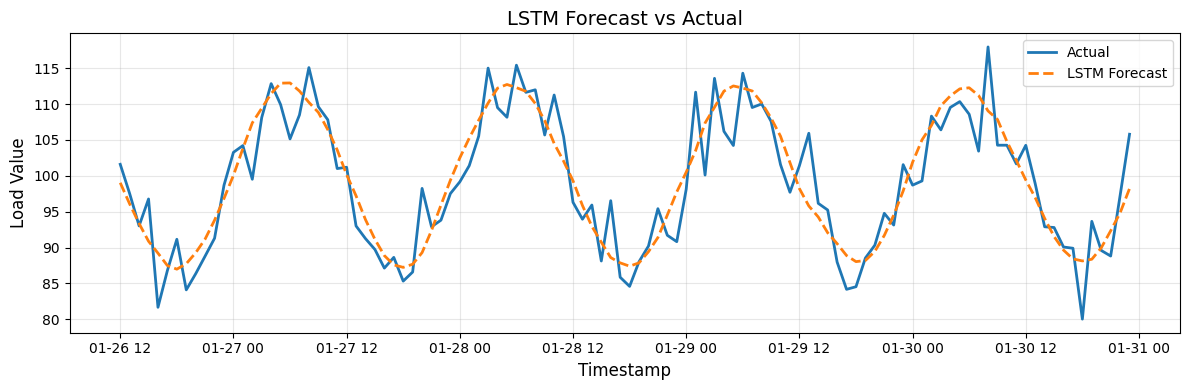

In [27]:
# -------------------------------------------------------------
# VISUALIZATION
# -------------------------------------------------------------
plt.figure(figsize=(12,4))

# Plot actual values
plt.plot(idx_test, y_test, label="Actual", linewidth=2)

# Plot LSTM predictions
plt.plot(idx_test, pred, '--', label="LSTM Forecast", linewidth=2)

# Title of the plot
plt.title("LSTM Forecast vs Actual", fontsize=14)

# Axis labels
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Load Value", fontsize=12)

# Grid, legend, and layout
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()
